In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import model_confs as confs
import singletask_dep as st

import train

from gensim.models import KeyedVectors

c:\Users\kuina\anaconda3\envs\tfg\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

word2vec_path = r"C:\Users\kuina\gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz"
word2vec_model =  KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

encoding_type = 'absolute'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


vocabulary = set(generic.create_word_to_index(convai_train).keys()) & set(word2vec_model.key_to_index.keys())
word_to_index = {}
emb_weights = []
for new_id, word in zip(range(len(vocabulary)),vocabulary):
    word_to_index[word] = new_id
    emb_weights.append(word2vec_model[word])

emb_weights = np.array(emb_weights)



In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)
convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,deps=True)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# Prueba hiperparámetros 1

In [14]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

## ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6846293654383683 	 Validation loss: 0.6849780486801923 	 
  1%|          | 574/57400 [00:05<08:45, 108.15it/s]
Epoch 2 	 Training loss: 0.6824753797428118 	 Validation loss: 0.6839731921583919 	 
  2%|▏         | 1148/57400 [00:11<08:14, 113.66it/s]
Epoch 3 	 Training loss: 0.6814666660405202 	 Validation loss: 0.6837132664050086 	 
  3%|▎         | 1722/57400 [00:16<08:25, 110.15it/s]
Epoch 4 	 Training loss: 0.6810615909016506 	 Validation loss: 0.6838558730432542 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:22<08:05, 113.60it/s]
Epoch 5 	 Training loss: 0.6809255843170844 	 Validation loss: 0.6836629954435057 	 
  5%|▌         | 2870/57400 [00:27<08:09, 111.42it/s]
Epoch 6 	 Training loss: 0.6808139706737903 	 Validation loss: 0.6835503052856963 	 
  6%|▌         | 3444/57400 [00:33<08:02, 111.82it/s]
Epoch 7 	 Training loss: 0.6808471660996148 	 Validation loss: 0.6837321095547434 	 

1 epoch without improvement
  7%|▋         | 4018/57

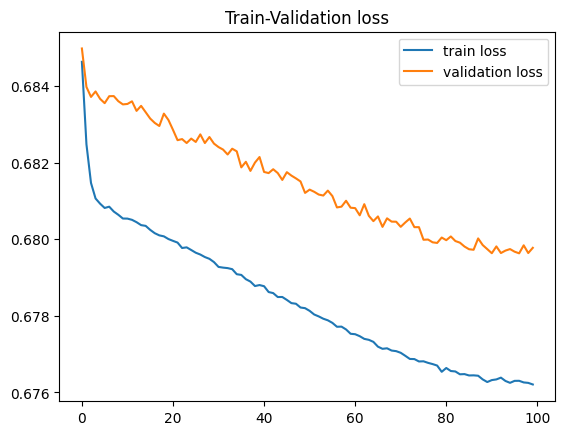

In [16]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [17]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6930584929338316 	 Validation loss: 0.6905551572977486 	 
  1%|          | 574/57400 [00:05<08:33, 110.57it/s]
Epoch 2 	 Training loss: 0.6878141324694563 	 Validation loss: 0.6871847166853436 	 
  2%|▏         | 1148/57400 [00:11<08:31, 110.01it/s]
Epoch 3 	 Training loss: 0.6844996439247597 	 Validation loss: 0.6851732852095265 	 
  3%|▎         | 1722/57400 [00:16<08:32, 108.70it/s]
Epoch 4 	 Training loss: 0.6826391944901868 	 Validation loss: 0.6843773985313157 	 
  4%|▍         | 2296/57400 [00:22<08:19, 110.37it/s]
Epoch 5 	 Training loss: 0.6816077048562545 	 Validation loss: 0.6838586269798925 	 
  5%|▌         | 2870/57400 [00:27<08:19, 109.07it/s]
Epoch 6 	 Training loss: 0.6812608722818022 	 Validation loss: 0.6835395057322615 	 
  6%|▌         | 3444/57400 [00:33<08:09, 110.31it/s]
Epoch 7 	 Training loss: 0.6810841837618824 	 Validation loss: 0.6837427818169028 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [00:38<07:59, 111.32it/s]

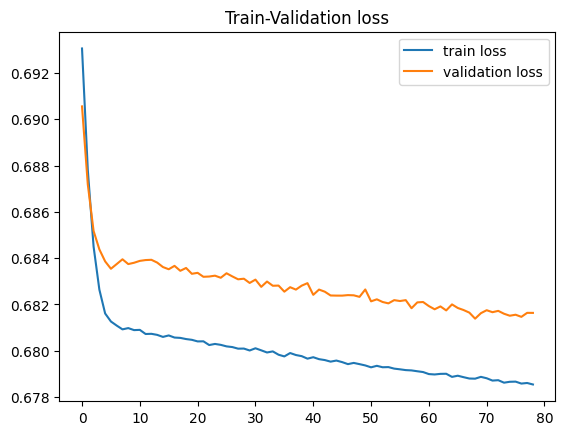

In [18]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [19]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.696706912762612 	 Validation loss: 0.6926325923305446 	 
  1%|          | 574/57400 [00:05<08:32, 110.83it/s]
Epoch 2 	 Training loss: 0.6896169216790681 	 Validation loss: 0.687989965333777 	 
  2%|▏         | 1148/57400 [00:11<08:20, 112.47it/s]
Epoch 3 	 Training loss: 0.6853555454402019 	 Validation loss: 0.6855741628145767 	 
  3%|▎         | 1722/57400 [00:16<08:20, 111.34it/s]
Epoch 4 	 Training loss: 0.682972839588903 	 Validation loss: 0.6843814718521247 	 
  4%|▍         | 2296/57400 [00:22<08:16, 111.06it/s]
Epoch 5 	 Training loss: 0.6819690201132971 	 Validation loss: 0.6839646606122033 	 
  5%|▌         | 2870/57400 [00:27<08:04, 112.50it/s]
Epoch 6 	 Training loss: 0.6814835427737818 	 Validation loss: 0.6842122411323805 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:33<08:04, 111.26it/s]
Epoch 7 	 Training loss: 0.6813699439012215 	 Validation loss: 0.6839170263985456 	 
  7%|▋         | 4018/57400 [00:38<07:54, 112.51it/s]
Ep

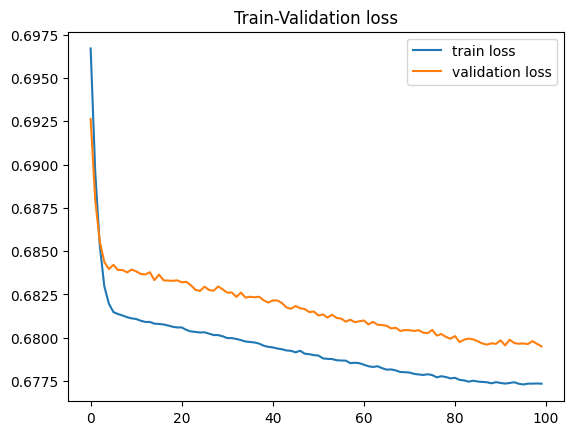

In [20]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [21]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



In [22]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
Métricas etiqueta male: {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
Métricas etiqueta female:  {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}

 to
Resultado global: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
Métricas etiqueta male: {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
Métricas etiqueta female:  {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}

 as
Resultado global: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
Métricas etiqueta male: {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
Métricas etiqueta female:  {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}


## TO

In [23]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6950217971403009 	 Validation loss: 0.6959130400318211 	 
  1%|          | 574/57400 [00:06<09:43, 97.38it/s]
Epoch 2 	 Training loss: 0.6939321869549435 	 Validation loss: 0.6947160757194131 	 
  2%|▏         | 1148/57400 [00:12<09:29, 98.85it/s]
Epoch 3 	 Training loss: 0.6934471098180431 	 Validation loss: 0.6938449669692476 	 
  3%|▎         | 1722/57400 [00:18<09:17, 99.91it/s]
Epoch 4 	 Training loss: 0.6933176027357786 	 Validation loss: 0.6932089702557709 	 
  4%|▍         | 2296/57400 [00:24<09:12, 99.78it/s]
Epoch 5 	 Training loss: 0.6933156750343402 	 Validation loss: 0.6932466979754173 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:07, 99.67it/s]
Epoch 6 	 Training loss: 0.693256183160722 	 Validation loss: 0.6929203180943505 	 
  6%|▌         | 3444/57400 [00:37<09:03, 99.36it/s]
Epoch 7 	 Training loss: 0.6932730262495499 	 Validation loss: 0.6930579866393137 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [00

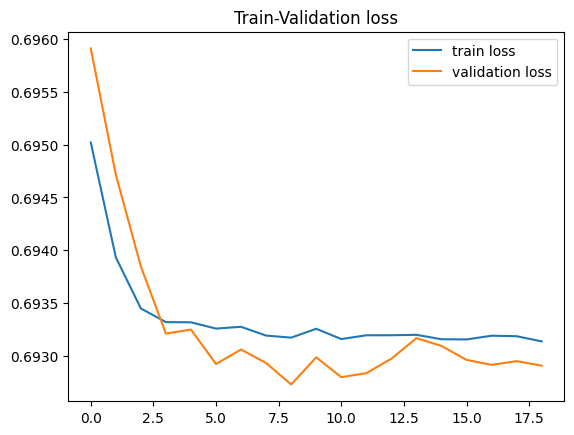

In [24]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [25]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.057291666666666664, 'precision': 0.057291666666666664, 'f1': 0.057291666666666664, 'accuracy': 0.057291666666666664}
FEMALE {'recall': 0.945, 'precision': 0.945, 'f1': 0.945, 'accuracy': 0.945} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48484848484848486, 'precision': 0.48484848484848486, 'f1': 0.48484848484848486, 'accuracy': 0.48484848484848486}
MALE {'recall': 0.051094890510948905, 'precision': 0.051094890510948905, 'f1': 0.05109489051094891, 'accuracy': 0.051094890510948905}
FEMALE {'recall': 0.952755905511811, 'precision': 0.952755905511811, 'f1': 0.952755905511811, 'accuracy': 0.952755905511811} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.49022164276401564, 'precision': 0.49022164276401564, 'f1': 0.49022164276401564, 'accuracy': 0.49022164276401564}
M

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6939219843842842 	 Validation loss: 0.6921366382453401 	 
  1%|          | 574/57400 [00:06<09:48, 96.63it/s]
Epoch 2 	 Training loss: 0.6933770976207813 	 Validation loss: 0.6921651131015712 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:28, 98.94it/s]
Epoch 3 	 Training loss: 0.693198936430004 	 Validation loss: 0.6925883272946891 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:20, 99.28it/s]
Epoch 4 	 Training loss: 0.6931656453667617 	 Validation loss: 0.6928193094366688 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:15, 99.21it/s]
Epoch 5 	 Training loss: 0.693165496874354 	 Validation loss: 0.6930198366359129 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:24, 96.56it/s]
Epoch 6 	 Training loss: 0.6931740046585894 	 Validation loss: 0.692927686844842 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:37<09:13, 97.45it/s]
Epoch 7 	 Training loss: 0.6930

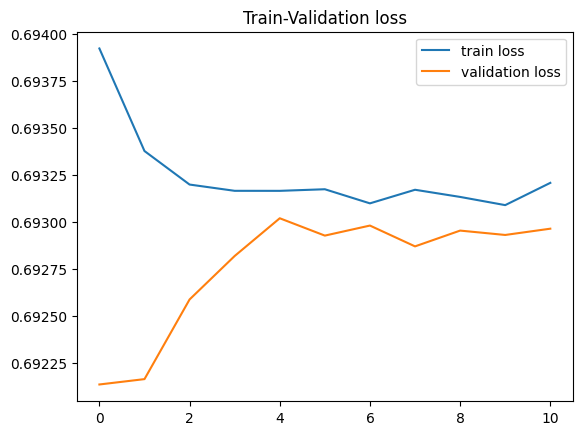

In [26]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [27]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932103302628321 	 Validation loss: 0.6932749950279624 	 
  1%|          | 574/57400 [00:06<09:25, 100.45it/s]
Epoch 2 	 Training loss: 0.6931562537930984 	 Validation loss: 0.6930491105984833 	 
  2%|▏         | 1148/57400 [00:12<09:20, 100.36it/s]
Epoch 3 	 Training loss: 0.693110075146479 	 Validation loss: 0.6930827124644134 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:19, 99.59it/s]
Epoch 4 	 Training loss: 0.6932156441103706 	 Validation loss: 0.6929876369945074 	 
  4%|▍         | 2296/57400 [00:24<09:14, 99.34it/s]
Epoch 5 	 Training loss: 0.6931490428771707 	 Validation loss: 0.6930680689165147 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:04, 100.16it/s]
Epoch 6 	 Training loss: 0.6931310716614075 	 Validation loss: 0.6930287712711399 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:37<09:10, 98.00it/s]
Epoch 7 	 Training loss: 0.6931304025110052 	 Validation loss: 0.693084431906878 	 


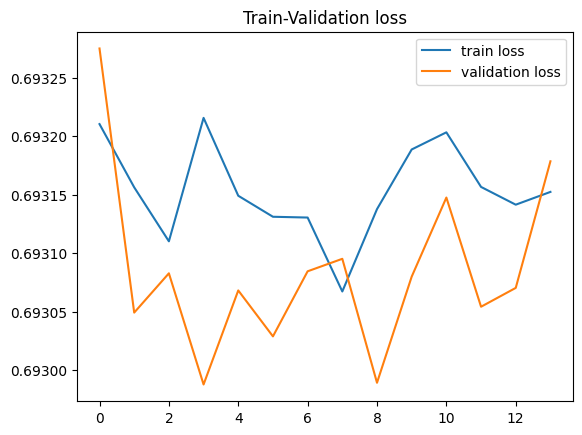

In [28]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [29]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4961734693877551, 'precision': 0.4961734693877551, 'f1': 0.4961734693877551, 'accuracy': 0.4961734693877551}
MALE {'recall': 0.3984375, 'precision': 0.3984375, 'f1': 0.3984375, 'accuracy': 0.3984375}
FEMALE {'recall': 0.59, 'precision': 0.59, 'f1': 0.59, 'accuracy': 0.59} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.45707070707070707, 'precision': 0.45707070707070707, 'f1': 0.45707070707070707, 'accuracy': 0.45707070707070707}
MALE {'recall': 0.3844282238442822, 'precision': 0.3844282238442822, 'f1': 0.38442822384428227, 'accuracy': 0.3844282238442822}
FEMALE {'recall': 0.5354330708661418, 'precision': 0.5354330708661418, 'f1': 0.5354330708661418, 'accuracy': 0.5354330708661418} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.49934810951760106, 'precision': 0.49934810951760106, 'f1': 0.49934810951760106, 'accuracy': 0.49934810951760106}
MALE {'recall': 0.4166666666666667, 'precision': 0.

In [30]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5055272108843537, 'precision': 0.5055272108843537, 'f1': 0.5055272108843537, 'accuracy': 0.5055272108843537}
Métricas etiqueta male: {'recall': 0.1519097222222222, 'precision': 0.1519097222222222, 'f1': 0.1519097222222222, 'accuracy': 0.1519097222222222}
Métricas etiqueta female:  {'recall': 0.845, 'precision': 0.845, 'f1': 0.845, 'accuracy': 0.845}

 to
Resultado global: {'recall': 0.4743265993265993, 'precision': 0.4743265993265993, 'f1': 0.4743265993265993, 'accuracy': 0.4743265993265993}
Métricas etiqueta male: {'recall': 0.1451743714517437, 'precision': 0.1451743714517437, 'f1': 0.14517437145174372, 'accuracy': 0.1451743714517437}
Métricas etiqueta female:  {'recall': 0.8293963254593176, 'precision': 0.8293963254593176, 'f1': 0.8293963254593176, 'accuracy': 0.8293963254593176}

 as
Resultado global: {'recall': 0.49109083007388094, 'precision': 0.49109083007388094, 'f1': 0.49109083007388094, 'accuracy': 0.49109083007388094

# AS

In [31]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933918381401886 	 Validation loss: 0.6920766880956747 	 
  1%|          | 574/57400 [00:06<09:34, 98.94it/s]
Epoch 2 	 Training loss: 0.6932784842281807 	 Validation loss: 0.6924806833267212 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:23, 99.78it/s]
Epoch 3 	 Training loss: 0.693241724361526 	 Validation loss: 0.692737508628328 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:09, 101.24it/s]
Epoch 4 	 Training loss: 0.6932165663209111 	 Validation loss: 0.6926251457909406 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:15, 99.17it/s]
Epoch 5 	 Training loss: 0.6931922790896187 	 Validation loss: 0.692962828329054 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:30<09:08, 99.35it/s]
Epoch 6 	 Training loss: 0.693234998693865 	 Validation loss: 0.6929648771124371 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:37<08:58, 100.19it/s]
Epoch 7 	 Training loss: 0.693

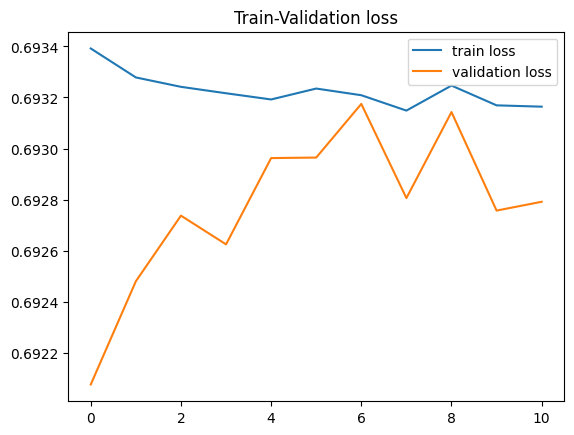

In [32]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [33]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0078125, 'precision': 0.0078125, 'f1': 0.0078125, 'accuracy': 0.0078125}
FEMALE {'recall': 0.9925, 'precision': 0.9925, 'f1': 0.9925, 'accuracy': 0.9925} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.012165450121654502, 'precision': 0.012165450121654502, 'f1': 0.012165450121654502, 'accuracy': 0.012165450121654502}
FEMALE {'recall': 0.9868766404199475, 'precision': 0.9868766404199475, 'f1': 0.9868766404199475, 'accuracy': 0.9868766404199475} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4784876140808344, 'precision': 0.4784876140808344, 'f1': 0.4784876140808344, 'accuracy': 0.4784876140808344}
MALE {'recall': 0.010101010101010102, 'preci

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932380962662581 	 Validation loss: 0.6932531463897834 	 
  1%|          | 574/57400 [00:06<09:24, 100.72it/s]
Epoch 2 	 Training loss: 0.6933090234052014 	 Validation loss: 0.6930662019778107 	 
  2%|▏         | 1148/57400 [00:12<09:31, 98.51it/s]
Epoch 3 	 Training loss: 0.6933630095334004 	 Validation loss: 0.6932031421338097 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:30, 97.55it/s]
Epoch 4 	 Training loss: 0.6932900928038753 	 Validation loss: 0.6928447434457682 	 
  4%|▍         | 2296/57400 [00:24<09:06, 100.87it/s]
Epoch 5 	 Training loss: 0.6931361619396077 	 Validation loss: 0.6930647957122932 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:30<09:02, 100.50it/s]
Epoch 6 	 Training loss: 0.6932144301070569 	 Validation loss: 0.693058641280158 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:37<08:54, 100.93it/s]
Epoch 7 	 Training loss: 0.6932456846436557 	 Validation loss: 0.6930577411489972 	

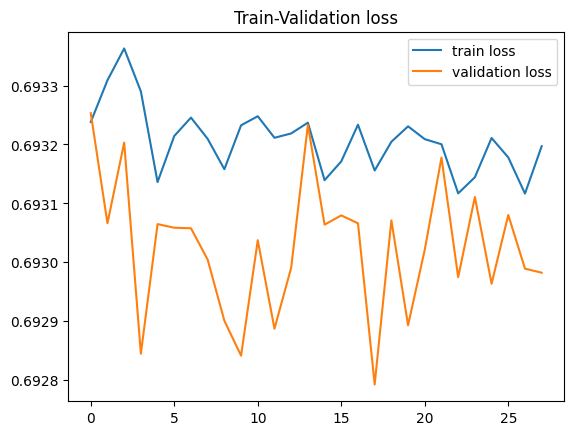

In [34]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [35]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5306122448979592, 'precision': 0.5306122448979592, 'f1': 0.5306122448979592, 'accuracy': 0.5306122448979592}
MALE {'recall': 0.2526041666666667, 'precision': 0.2526041666666667, 'f1': 0.2526041666666667, 'accuracy': 0.2526041666666667}
FEMALE {'recall': 0.7975, 'precision': 0.7975, 'f1': 0.7975, 'accuracy': 0.7975} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48737373737373735, 'precision': 0.48737373737373735, 'f1': 0.48737373737373735, 'accuracy': 0.48737373737373735}
MALE {'recall': 0.25304136253041365, 'precision': 0.25304136253041365, 'f1': 0.25304136253041365, 'accuracy': 0.25304136253041365}
FEMALE {'recall': 0.7401574803149606, 'precision': 0.7401574803149606, 'f1': 0.7401574803149605, 'accuracy': 0.7401574803149606} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4810951760104302, 'precision': 0.4810951760104302, 'f1': 0.4810951760104302, 'accuracy': 0.4810951760104302}
MALE {'r

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933988859221495 	 Validation loss: 0.6921376828419961 	 
  1%|          | 574/57400 [00:06<22:46, 41.58it/s]
Epoch 2 	 Training loss: 0.6931956616012892 	 Validation loss: 0.6925661169876487 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:19, 100.56it/s]
Epoch 3 	 Training loss: 0.6931300317991901 	 Validation loss: 0.6927384269439568 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:19<09:15, 100.17it/s]
Epoch 4 	 Training loss: 0.6931967220239938 	 Validation loss: 0.6927905325162209 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:25<09:18, 98.72it/s]
Epoch 5 	 Training loss: 0.6931808472510415 	 Validation loss: 0.692849118830794 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:31<08:59, 101.09it/s]
Epoch 6 	 Training loss: 0.693141836634081 	 Validation loss: 0.6929751472958063 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:37<08:55, 100.82it/s]
Epoch 7 	 Training loss: 0

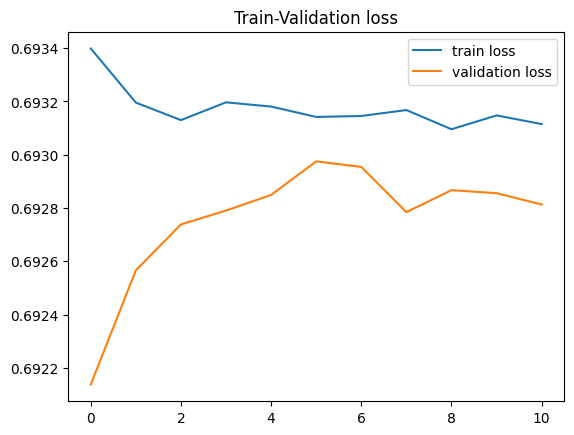

In [36]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [37]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



In [38]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5170068027210885, 'precision': 0.5170068027210885, 'f1': 0.5170068027210885, 'accuracy': 0.5170068027210885}
Métricas etiqueta male: {'recall': 0.08680555555555557, 'precision': 0.08680555555555557, 'f1': 0.08680555555555557, 'accuracy': 0.08680555555555557}
Métricas etiqueta female:  {'recall': 0.93, 'precision': 0.93, 'f1': 0.93, 'accuracy': 0.93}

 to
Resultado global: {'recall': 0.4831649831649832, 'precision': 0.4831649831649832, 'f1': 0.4831649831649832, 'accuracy': 0.4831649831649832}
Métricas etiqueta male: {'recall': 0.08840227088402272, 'precision': 0.08840227088402272, 'f1': 0.08840227088402272, 'accuracy': 0.08840227088402272}
Métricas etiqueta female:  {'recall': 0.9090113735783028, 'precision': 0.9090113735783028, 'f1': 0.9090113735783026, 'accuracy': 0.9090113735783028}

 as
Resultado global: {'recall': 0.4810951760104302, 'precision': 0.4810951760104302, 'f1': 0.4810951760104302, 'accuracy': 0.4810951760104302}